In [1]:
from dataclasses import dataclass
from enum import Enum


class Stage(Enum):
    PREFILL = "Prefill"
    DECODE = "Decode"


@dataclass
class BatchPredictionInfo:
    batch_size: int
    avg_context_len: int


@dataclass
class PredictionInput:
    gpu: str  # or a custom GPU object/type
    stage: Stage
    tp_size: int
    num_new_tokens: float
    prod_ext_ctx: float
    num_context_tokens: float
    batch_size: float


class Predictor:
    def predict(self, input_data: PredictionInput) -> float:
        # placeholder for actual prediction logic
        raise NotImplementedError

    def predict_batch_with_features_ms(self, gpu, tp_size: int, batch: BatchPredictionInfo, stage: Stage) -> float:
        if stage == Stage.PREFILL:
            num_new_tokens = batch.batch_size * batch.avg_context_len
            prod_ext_ctx = batch.batch_size * (batch.avg_context_len ** 2)
            num_context_tokens = batch.avg_context_len * batch.batch_size
            num_batch_size = batch.batch_size
        else: # DECODE
            num_new_tokens = batch.batch_size
            prod_ext_ctx = batch.batch_size * batch.avg_context_len
            num_context_tokens = batch.avg_context_len * batch.batch_size
            num_batch_size = batch.batch_size

        prediction_input = PredictionInput(
            gpu=gpu,
            stage=stage,
            tp_size=tp_size,
            num_new_tokens=float(num_new_tokens),
            prod_ext_ctx=float(prod_ext_ctx),
            num_context_tokens=float(num_context_tokens),
            batch_size=float(num_batch_size)
        )

        return self.predict(prediction_input)

In [2]:
with open("benchmark_cache/results_00cf68676d2b0f09a60a818e0923e8ba.json", "r") as f:
    # Assuming the file contains JSON data that can be parsed
    import json
    results = json.load(f)


In [3]:
import pandas as pd
df = pd.DataFrame(results["results"])
def build_stage_features(df: pd.DataFrame, stage: str) -> pd.DataFrame:
    """
    Build input features for latency modeling based on the inference stage.
    Returns
    -------
    pd.DataFrame
        A dataframe with engineered features:
        - num_new_tokens: total tokens processed/generated (models token compute)
        - prod_ext_ctx: proxy for attention cost (quadratic or linear depending on stage)
        - num_context_tokens: total context tokens active (models memory + cache pressure)
        - batch_size: degree of parallelism
        - time: latency target to be predicted
    """
    df = df.copy()

    if stage == "prefill":
        # Each request has `input_len` tokens; all tokens are processed in parallel
        # Attention complexity is O(seq_len^2) per request
        df["num_new_tokens"] = df["batch_size"] * df["input_len"]
        df["prod_ext_ctx"] = df["batch_size"] * (df["input_len"] ** 2)
        df["num_context_tokens"] = df["batch_size"] * df["input_len"]
        df["time"] = df["prefill_latency"]

    elif stage == "decode":
        # One token is generated per request per step
        # Each new token attends to all previous context (linear in output_len)
        df["num_new_tokens"] = df["batch_size"]
        df["prod_ext_ctx"] = df["batch_size"] * df["output_len"]
        df["num_context_tokens"] = df["batch_size"] * df["input_len"]
        df["time"] = df["median_decode_latency"]

    else:
        raise ValueError("stage must be either 'prefill' or 'decode'")

    return df[["num_new_tokens", "prod_ext_ctx", "num_context_tokens", "batch_size", "time"]]

train_df_prefill = build_stage_features(df, stage="prefill")
train_df_decode = build_stage_features(df, stage="decode")

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Prepare prefill data
X_train_prefill = train_df_prefill[
    ['num_new_tokens', 'prod_ext_ctx', 'num_context_tokens', 'batch_size']
].to_numpy(dtype=np.float32)
y_train_prefill = train_df_prefill['time'].to_numpy(dtype=np.float32)

# Fit a RF on prefill
rf_model_prefill = RandomForestRegressor(
    n_estimators=10, random_state=42, min_samples_leaf=2, max_depth=12
)
rf_model_prefill.fit(X_train_prefill, y_train_prefill)
y_pred_prefill = rf_model_prefill.predict(X_train_prefill)

# Metrics
print("Prefill Train MSE:", mean_squared_error(y_train_prefill, y_pred_prefill) * 1000)
print("Prefill Train MAE:", mean_absolute_error(y_train_prefill, y_pred_prefill) * 1000)
print("Prefill Train R²:", r2_score(y_train_prefill, y_pred_prefill))

Prefill Train MSE: 0.1649355917473599
Prefill Train MAE: 5.158364328651359
Prefill Train R²: 0.9910235473579526


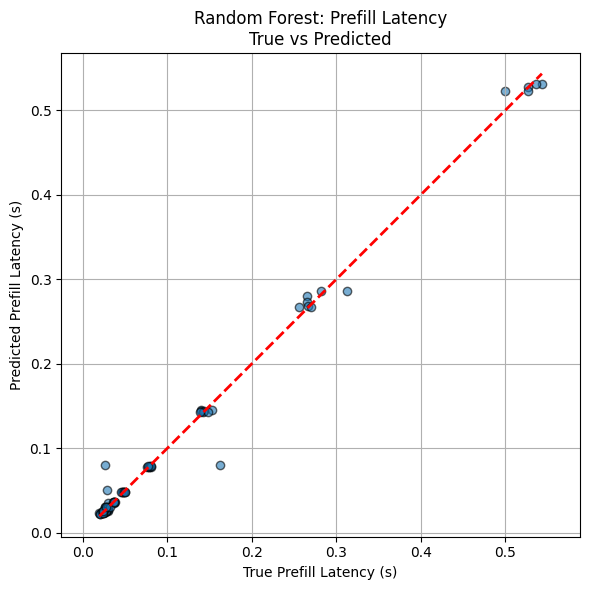

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_train_prefill, y_pred_prefill, alpha=0.6, edgecolor='k')
plt.plot([y_train_prefill.min(), y_train_prefill.max()],
         [y_train_prefill.min(), y_train_prefill.max()], 'r--', lw=2)
plt.xlabel("True Prefill Latency (s)")
plt.ylabel("Predicted Prefill Latency (s)")
plt.title("Random Forest: Prefill Latency\nTrue vs Predicted")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
X_train = train_df_decode[['num_new_tokens', 'prod_ext_ctx', 'num_context_tokens', 'batch_size']].to_numpy(dtype=np.float32)
y_train = train_df_decode['time'].to_numpy(dtype=np.float32)

rf_model_decode = RandomForestRegressor(n_estimators=10, random_state=42, min_samples_leaf=2, max_depth=12)
rf_model_decode.fit(X_train, y_train)
y_pred = rf_model_decode.predict(X_train)

print("Train MSE:", mean_squared_error(y_train, y_pred))
print("Train MAE:", mean_absolute_error(y_train, y_pred) * 1000)
print("Train R²:", r2_score(y_train, y_pred))

Train MSE: 2.032618439998463e-07
Train MAE: 0.27775247489353516
Train R²: 0.7970249417225114


In [7]:
from sklearn.linear_model import LinearRegression

# Same input/output
X_train = train_df_decode[['num_new_tokens', 'prod_ext_ctx', 'num_context_tokens', 'batch_size']].to_numpy(dtype=np.float32)
y_train = train_df_decode['time'].to_numpy(dtype=np.float32)

# Fit Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_train)

print("Linear Regression:")
print("Train MSE:", mean_squared_error(y_train, y_pred_lr))
print("Train MAE:", mean_absolute_error(y_train, y_pred_lr))
print("Train R²:", r2_score(y_train, y_pred_lr))


Linear Regression:
Train MSE: 4.828222017749795e-07
Train MAE: 0.0005002233665436506
Train R²: 0.5178589820861816


In [19]:
from sklearn.linear_model import LinearRegression

# Same input/output
X_train = train_df_prefill[['num_new_tokens', 'prod_ext_ctx', 'num_context_tokens', 'batch_size']].to_numpy(dtype=np.float32)
y_train = train_df_prefill['time'].to_numpy(dtype=np.float32)

# Fit Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_train)

print("Linear Regression:")
print("Train MSE:", mean_squared_error(y_train, y_pred_lr) * 1000)
print("Train MAE:", mean_absolute_error(y_train, y_pred_lr) * 1000)
print("Train R²:", r2_score(y_train, y_pred_lr))


Linear Regression:
Train MSE: 0.28271874180063605
Train MAE: 6.002300418913364
Train R²: 0.984613299369812


In [9]:
from numba import njit

@njit
def fast_predict_jit(X, weights, bias):
    return X @ weights + bias

In [17]:
import time

# pick a single sample (reshape to 2D)
sample = X_train[50].reshape(1, -1)

# profile RandomForestRegressor
start = time.perf_counter()
rf_model_decode.predict(sample)
rf_elapsed = time.perf_counter() - start

# profile LinearRegression
start = time.perf_counter()
lr_model.predict(sample)
lr_elapsed = time.perf_counter() - start


weights = lr_model.coef_.astype(np.float32)  # shape (n_features,)
bias = float(lr_model.intercept_)
start_time = time.perf_counter()
pred_lr = np.dot(sample, weights) + bias
lr_elapsed = time.perf_counter() - start_time   

print(f"RF predict time: {rf_elapsed * 1e6:.2f} µs")
print(f"LR predict time: {lr_elapsed * 1e6:.2f} µs")
print(f"Custom LR predict time: {lr_elapsed * 1e6:.2f} µs")

RF predict time: 914.13 µs
LR predict time: 43.26 µs
Custom LR predict time: 43.26 µs


In [18]:
sample

array([[ 64., 256.,  64.,  16.]], dtype=float32)

In [81]:
weights, bias

(array([2.9355213e-05, 2.6159412e-09, 2.9355213e-05, 1.1957977e-07],
       dtype=float32),
 0.023666933178901672)

In [ ]:
import pandas as pd
import numpy as np

# Generate mock training data
train_data = {
    'num_new_tokens': np.random.randint(1, 10, size=100),
    'prod_ext_ctx': np.random.uniform(0.0, 1.0, size=100),
    'num_context_tokens': np.random.randint(50, 200, size=100),
    'batch_size': np.random.randint(1, 16, size=100),
    'time': np.random.uniform(0.5, 5.0, size=100)  # target variable
}
train_df_decode = pd.DataFrame(train_data)

# Generate mock test data
test_data = {
    'num_new_tokens': np.random.randint(1, 10, size=20),
    'prod_ext_ctx': np.random.uniform(0.0, 1.0, size=20),
    'num_context_tokens': np.random.randint(50, 200, size=20),
    'batch_size': np.random.randint(1, 16, size=20),
    'time': np.random.uniform(0.5, 5.0, size=20)  # true target for evaluation
}
test_df_decode = pd.DataFrame(test_data)

# Display some sample data
print("Training Data Sample:")
print(train_df_decode.head())

print("\nTest Data Sample:")
print(test_df_decode.head())



Training Data Sample:
   num_new_tokens  prod_ext_ctx  num_context_tokens  batch_size      time
0               7      0.751715                 116           3  1.584784
1               6      0.805424                 109           8  4.373438
2               9      0.931937                 111          13  3.340471
3               4      0.358918                 192          11  0.624205
4               6      0.924514                  78          14  2.207557

Test Data Sample:
   num_new_tokens  prod_ext_ctx  num_context_tokens  batch_size      time
0               4      0.385448                 185           6  0.531763
1               2      0.337863                 137          12  4.128742
2               2      0.883983                 127          10  4.720189
3               9      0.661420                 125           8  2.442146
4               5      0.541860                  65           4  4.681470


In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Define and train your regressor (assuming train_df_decode is defined)
rf_model_decode = RandomForestRegressor(n_estimators=10, random_state=42, min_samples_leaf=2, max_depth=12)

X_train = train_df_decode[['num_new_tokens', 'prod_ext_ctx', 'num_context_tokens', 'batch_size']].to_numpy(dtype=np.float32)
y_train = train_df_decode['time'].to_numpy(dtype=np.float32)

rf_model_decode.fit(X_train, y_train)

# Convert to ONNX with explicit opset version
initial_type = [('float_input', FloatTensorType([None, 4]))]  # 4 features
onnx_model = convert_sklearn(
    rf_model_decode,
    initial_types=initial_type,
    target_opset=12  # or 11, depending on your ONNX Runtime version
)

# Save the ONNX model
with open("regressor_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("ONNX regression model saved as regressor_model.onnx")


ONNX regression model saved as regressor_model.onnx


In [10]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import pickle
with open("trace_datasets/A100_TP2_Llama3p1_8B_extend.pkl", "rb") as f:
    rf_model_decode = pickle.load(f)

# Convert to ONNX with explicit opset version
initial_type = [('float_input', FloatTensorType([None, 4]))]  # 4 features
onnx_model = convert_sklearn(
    rf_model_decode,
    initial_types=initial_type,
    target_opset=12  # or 11, depending on your ONNX Runtime version
)

# Save the ONNX model
with open("a100_tp12_predictor.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("ONNX regression model saved as regressor_model.onnx")


ONNX regression model saved as regressor_model.onnx


In [11]:
import onnx
model = onnx.load("model_predictor_decision_trees/model_predictors_onyx/A100_TP1_Llama3p1_8B_extend.onnx")
onnx.checker.check_model(model)   # will throw if graph is missing/invalid
print(model.graph)                # inspect the graph protobuf


ValidationError: The model does not have an ir_version set properly.

RandomForestRegressor(n_estimators=20, random_state=42)